##### Copyright 2021 Google LLC

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Graph regularization for image classification using synthesized graphs

*By [Sayak Paul](https://sayak.dev)*

<br>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/neural-structured-learning/blob/master/neural_structured_learning/examples/notebooks/graph_keras_cnn_flowers.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/neural-structured-learning/blob/master/neural_structured_learning/examples/notebooks/graph_keras_cnn_flowers.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

This notebook is the counterpart of [Graph regularization for sentiment 
classification using synthesized graphs](https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_lstm_imdb) for image classification. In this notebook, we will build a flower classification model that can categorize images of flowers into discrete classes such as sunflowers, roses,
tulips, etc. 

We will demonstrate the use of graph regularization in this notebook by building a graph from the given input. The general recipe for building a graph-regularized model using the Neural Structured Learning (NSL) framework when the input does not contain an explicit graph is as follows:

1.  Create embeddings for each image sample in the input. This can be done using
    pre-trained models such as [EfficientNet](https://arxiv.org/abs/1905.11946),
    [Inception](https://arxiv.org/abs/1512.00567),
    [BiT](https://arxiv.org/abs/1912.11370) etc.
2.  Build a graph based on these embeddings by using a similarity metric such as
    the 'L2' distance, 'cosine' distance, etc. Nodes in the graph correspond to
    samples and edges in the graph correspond to similarity between pairs of
    samples.
3.  Generate training data from the above synthesized graph and sample features.
    The resulting training data will contain neighbor features in addition to
    the original node features.
4.  Create a neural network as a base model using the Keras sequential,
    functional, or subclass API.
5.  Wrap the base model with the GraphRegularization wrapper class, which is
    provided by the NSL framework, to create a new graph Keras model. This new
    model will include a graph regularization loss as the regularization term in
    its training objective.
6.  Train and evaluate the graph Keras model.

**Note**: We expect that it would take readers about 1 hour to go through this
tutorial.

## Requirements

1.  Install the Neural Structured Learning package.
2.  Install tensorflow-hub.

In [1]:
!pip install --quiet neural-structured-learning
!pip install --quiet tensorflow-hub

     |████████████████████████████████| 120 kB 8.5 MB/s 


## Dependencies and imports

In [2]:
from sklearn.random_projection import gaussian_random_matrix
import matplotlib.pyplot as plt
import numpy as np

import neural_structured_learning as nsl

import tensorflow as tf
import tensorflow_datasets as tfds

# Resets notebook state
tf.keras.backend.clear_session()

tfds.disable_progress_bar()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print(
  "GPU is",
  "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.6.0
Eager mode:  True
GPU is available


## Flowers dataset

The flowers dataset contains a total of 3670 images of flowers categorized into 5 classes - 

* daisy
* dandelion
* roses
* sunflowers
* tulips

The dataset is balanced i.e., each class contains roughly the same number of examples. In the cells below, we first load the dataset using [TensorFlow Datasets](https://www.tensorflow.org/datasets) and then visualize a couple of examples from the dataset. 

The dataset does not come pre-split into training, validation, and test splits. However, when downloading the dataset, we can specify a splitting ratio. Here we'll be using a split of 85:15 for the training and validation sets.

In [3]:
train_ds, validation_ds = tfds.load(
  "tf_flowers",
  split=["train[:85%]", "train[85%:]"],
  as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


After downloading the dataset and splitting it, we can visualize a few samples from it. 

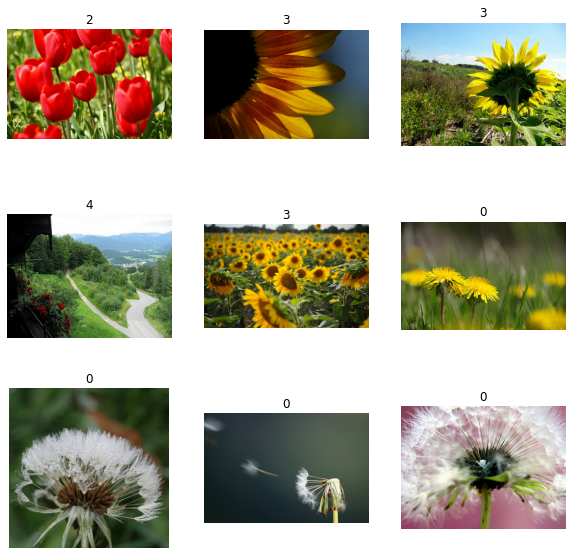

In [4]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

In the next cell, we determine the number of samples present in the splits.

In [5]:
num_train_examples = tf.data.experimental.cardinality(train_ds)
num_val_examples = tf.data.experimental.cardinality(validation_ds)
print(f"Total training examples: {num_train_examples}")
print(f"Total validation examples: {num_val_examples}")

Total training examples: 3120
Total validation examples: 550


## Graph construction

Graph construction involves creating embeddings for the images and then using
a similarity function to compare the embeddings.

### Create sample embeddings

We will use a pre-trained [DenseNet121](https://arxiv.org/abs/1608.06993) model to create embeddings in the
`tf.train.Example` format for each sample in the input. We will store the
resulting embeddings in the `TFRecord` format along with an additional feature
that represents the ID of each sample. This is important and will allow us match
sample embeddings with corresponding nodes in the graph later. We'll start this section with a utility function to build a feature extraction model.

One important detail to note here is that we are using [random projections](https://en.wikipedia.org/wiki/Random_projection) in order to reduce the dimensionality of the final vector coming out of the pre-trained model. The final embedding vector is 1024-dimensional. When the size of the dataset is large, such high-dimensional vectors can consume a lot of memory. Hence depending on your use-case, it might be a good idea to further reduce the dimensionality. 

In [6]:
IMG_SIZE = 224 #@param ["128", "224"] {type:"raw"}
PROJECTED_DIM = 128 #@param {type:"slider", min:128, max:1024, step:128}
#@markdown `IMG_SIZE` of 224 denotes the 224 $\times$ 224 resolution.

In [7]:
def create_feature_extractor_model():
  """Creates a feature extractor model with DenseNet121."""
  inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
  
  densenet_model = tf.keras.applications.DenseNet121(weights="imagenet", 
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg", include_top=False
  )
  densenet_model.trainable = False
  x = tf.keras.applications.densenet.preprocess_input(inputs)
  outputs = densenet_model(x, training=False)

  return tf.keras.Model(inputs, outputs, name="densenet_feature_extractor")

In [8]:
feature_extractor = create_feature_extractor_model()
feature_extractor.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


We encourage you to try out other pre-trained models available in the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module and also on [TensorFlow Hub](https://tfhub.dev/s?fine-tunable=yes&module-type=image-feature-vector&publisher=google,tensorflow&tf-version=tf2). We'll now write a couple of utility functions to create the sample embeddings for graph construction.

In [9]:
def resize(image, label):
  """Resizes the images to (IMG_SIZE x IMG_SIZE) size."""
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

# Resize all the images to uniform shape so that they can
# be batched.
train_ds = train_ds.map(resize)
validation_ds = validation_ds.map(resize)

In [10]:
def _int64_feature(value):
  """Returns int64 tf.train.Feature."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value.tolist()))


def _bytes_feature(value):
  """Returns bytes tf.train.Feature."""
  return tf.train.Feature(
    bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))


def _float_feature(value):
  """Returns float tf.train.Feature."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value.tolist()))


def create_embedding_example(feature_extractor, image,
                             projection_matrix, record_id):
  """Create tf.Example containing the sample's embedding and its ID."""

  image_features = feature_extractor(image[None, ...])
  image_features_numpy = image_features.numpy().squeeze()
  compressed_image_features = image_features_numpy.dot(projection_matrix)

  features = {
    "id": _bytes_feature(str(record_id)),
    "embedding": _float_feature(compressed_image_features)
  }
  return tf.train.Example(features=tf.train.Features(feature=features))


def generate_random_projection_weights(original_dim=1024,
                                       projected_dim=PROJECTED_DIM):
  """Generates a random projection matrix."""
  random_projection_matrix = gaussian_random_matrix(
    n_components=projected_dim, n_features=original_dim).T
  return random_projection_matrix


def create_embeddings(feature_extractor, dataset, output_path,
                      starting_record_id):
  """Creates TFRecords with embeddings of the images."""
  projection_matrix = generate_random_projection_weights()
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(output_path) as writer:
    for image, _ in dataset:
      example = create_embedding_example(feature_extractor,
                                         image,
                                         projection_matrix,
                                         record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id


# Persist TF.Example features containing embeddings for training data in
# TFRecord format.
create_embeddings(feature_extractor, train_ds, "flowers_embeddings.tfr", 0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function gaussian_random_matrix is deprecated; gaussian_random_matrix is deprecated in 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3120

### Graph building

Now that we have the sample embeddings, we will use them to build a similarity
graph, i.e, nodes in this graph will correspond to samples and edges in this
graph will correspond to similarity between pairs of nodes.

Neural Structured Learning provides a graph building library to build a graph
based on sample embeddings. It uses
[**cosine similarity**](https://en.wikipedia.org/wiki/Cosine_similarity) as the
similarity measure to compare embeddings and build edges between them. It also
allows us to specify a similarity threshold, which can be used to discard
dissimilar edges from the final graph. In this example, using 0.7 as the
similarity threshold and 12345 as the random seed, we end up with a graph that
has 132,117 bi-directional edges. Here we're using the graph builder's support
for [locality-sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing)
(LSH) to speed up graph building. For details on using the graph builder's LSH
support, see the
[`build_graph_from_config`](https://www.tensorflow.org/neural_structured_learning/api_docs/python/nsl/tools/build_graph_from_config)
API documentation.

In [11]:
similarity_threshold = 0.7 
graph_builder_config = nsl.configs.GraphBuilderConfig(
    similarity_threshold=similarity_threshold, 
    lsh_splits=10, lsh_rounds=15, random_seed=12345)
nsl.tools.build_graph_from_config(["flowers_embeddings.tfr"],
                                  "flowers_graph_70.tsv",
                                  graph_builder_config)

Each bi-directional edge is represented by two directed edges in the output TSV
file, so that file contains 493,623 * 2 = 987,246 total lines:

In [12]:
!wc -l flowers_graph_70.tsv

987246 flowers_graph_70.tsv


## Sample features

We create sample features for our problem using the `tf.train.Example` format
and persist them in the `TFRecord` format. Each sample will include the
following three features:

1.  **id**: The node ID of the sample.
2.  **image**: A byte list containing raw image vectors.
3.  **label**: A singleton int64 identifying the target class of the image.

In [13]:
def _bytes_feature_image(value):
    """Returns bytes tf.train.Feature."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[value]))
    

def create_example(image, label, record_id):
    """Create tf.Example containing the image, label, and ID."""
    features = {
        "id": _bytes_feature(str(record_id)),
        "image": _bytes_feature_image(image.numpy()),
        "label": _int64_feature(np.asarray([label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=features))

def create_records(dataset, record_path, starting_record_id):
  """Generates TFRecords from a tf.data.Dataset object."""
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(record_path) as writer:
    for image, label in dataset:
      image = tf.cast(image, tf.uint8)
      image = tf.image.encode_jpeg(image, optimize_size=True,
                                    chroma_downsampling=False)
      
      example = create_example(image, label, record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id

# Persist TF.Example features (images and labels) for training and validation
# data in TFRecord format.
next_record_id = create_records(train_ds,
                                "train_data.tfr", 0)
create_records(validation_ds, "validation_data.tfr",
               next_record_id)

3670

**A note on `create_records()`**:

Images are serialized as byte-strings in TFRecords. `tf.image.encode_jpeg()` function allows us to do that in an optimal way (when `optimize_size` is set to `True`). Inputs to that function should be integers. This is why, we first cast the image to `tf.uint8` and then pass it to `tf.image.encode_jpeg()`. To know more, refer to [this tutorial](https://www.tensorflow.org/tutorials/load_data/tfrecord#walkthrough_reading_and_writing_image_data).

## Augment training data with graph neighbors

Since we have the sample features and the synthesized graph, we can generate the
augmented training data for Neural Structured Learning. The NSL framework
provides a library to combine the graph and the sample features to produce
the final training data for graph regularization. The resulting training data
will include original sample features as well as features of their corresponding
neighbors.

In this tutorial, we consider undirected edges and use a maximum of 3 neighbors
per sample to augment training data with graph neighbors.

In [14]:
nsl.tools.pack_nbrs(
    "train_data.tfr",
    "",
    "flowers_graph_70.tsv",
    "nsl_train_data.tfr",
    add_undirected_edges=True,
    max_nbrs=3
)

In [15]:
!ls -lh *_data.tfr

-rw-r--r-- 1 root root 406M Aug 27 12:10 nsl_train_data.tfr
-rw-r--r-- 1 root root 102M Aug 27 12:07 train_data.tfr
-rw-r--r-- 1 root root  19M Aug 27 12:07 validation_data.tfr


## Base model

We'll first build a model without graph regularization. We'll use a simple convolutional neural network (CNN) for the purpose of this tutorial. However, this can be easily replaced with more sophisticated network architectures. 

### Global variables

In [16]:
NBR_FEATURE_PREFIX = "NL_nbr_"
NBR_WEIGHT_SUFFIX = "_weight"

### Hyperparameters

We will use an instance of `HParams` to inclue various hyperparameters and
constants used for training and evaluation. We briefly describe each of them
below:

-   **num_classes**: There are 5 classes.

-   **num_train_examples** and **num_val_examples**: The number of training and          
	  validation examples respectively.

-   **distance_type**: This is the distance metric used to regularize the sample
    with its neighbors.

-   **graph_regularization_multiplier**: This controls the relative weight of
    the graph regularization term in the overall loss function.

-   **num_neighbors**: The number of neighbors used for graph regularization.
    This value has to be less than or equal to the `max_nbrs` argument used
    above when invoking `nsl.tools.pack_nbrs`.

-   **num_channels**: The number of channels to be used in the convolutional layers.

-   **kernel_size**: Kernel size to be used in the convolutional layers.  

-   **train_epochs**: The number of training epochs.

-   **batch_size**: Batch size used for training and evaluation.

-   **eval_steps**: The number of batches to process before deeming evaluation
    is complete. If set to `None`, all instances in the test set are evaluated.

In [17]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 5
    self.num_train_examples = num_train_examples
    self.num_val_examples = num_val_examples
    
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.3
    self.num_neighbors = 2

    ### network architecture parameters
    self.num_channels = 32
    self.kernel_size = 3
    
    ### training parameters
    self.train_epochs = 30 
    self.batch_size = 64 
    
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()

### Prepare the data

Now, we will prepare our dataset with TensorFlow's `data` module ([`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data)). This will include parsing the TFRecords, structuring them, batching them, and shuffling them if necessary.

In the next two cells, we first define a default value for the image examples which will come in handy when parsing the neighbor examples. Then we write a utility function to create the `tf.data.Dataset` objects which will be fed to our model in a moment.

In [18]:
default_jpeg_value = tf.ones((IMG_SIZE, IMG_SIZE, 3), dtype=tf.uint8)
default_jpeg_value *= 255
default_jpeg_value = tf.image.encode_jpeg(default_jpeg_value, optimize_size=True,
                                         chroma_downsampling=False)

In [19]:
def make_dataset(file_path, training=False):
  """Creates a `tf.data.TFRecordDataset`.

  Args:
    file_path: Name of the file in the `.tfrecord` format containing
      `tf.train.Example` objects.
    training: Boolean indicating if we are in training mode.

  Returns:
    An instance of `tf.data.TFRecordDataset` containing the `tf.train.Example`
    objects.
  """

  def parse_example(example_proto):
    """Extracts relevant fields from the `example_proto`.

    Args:
      example_proto: An instance of `tf.train.Example`.

    Returns:
      A pair whose first value is a dictionary containing relevant features
      and whose second value contains the ground truth labels.
    """
    feature_spec = {
      'image': tf.io.FixedLenFeature([], tf.string, 
                                      default_value=default_jpeg_value),
      'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1),
    }
    # We also extract corresponding neighbor features in a similar manner to
    # the features above during training.
    if training:
      for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'image')
        nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i,
                                         NBR_WEIGHT_SUFFIX)
        feature_spec[nbr_feature_key] = tf.io.FixedLenFeature([], tf.string,
                                            default_value=default_jpeg_value)

        # We assign a default value of 0.0 for the neighbor weight so that
        # graph regularization is done on samples based on their exact number
        # of neighbors. In other words, non-existent neighbors are discounted.
        feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
            [1], tf.float32, default_value=tf.constant([0.0]))
    
    features = tf.io.parse_single_example(example_proto, feature_spec)
    labels = features.pop('label')
    
    # We need to convert the byte-strings back to images.
    features['image'] = tf.image.decode_jpeg(features['image'], channels=3)
    if training:
      for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'image')
        features[nbr_feature_key] = tf.image.decode_jpeg(features[nbr_feature_key],
                                                         channels=3)

    return features, labels

  dataset = tf.data.TFRecordDataset([file_path])
  if training:
    dataset = dataset.shuffle(HPARAMS.batch_size * 10)
  dataset = dataset.map(parse_example)
  dataset = dataset.batch(HPARAMS.batch_size)
  return dataset


train_dataset = make_dataset('nsl_train_data.tfr', True)
validation_dataset = make_dataset('validation_data.tfr')

### Model training (no graph regularization)

With our datasets prepared, we are now ready to train our shallow CNN model *without* graph regularization.

In [21]:
def make_cnn_model():
  """Creates a simple CNN model."""
  model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
    tf.keras.layers.Conv2D(HPARAMS.num_channels, HPARAMS.kernel_size, 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(HPARAMS.num_channels, HPARAMS.kernel_size, 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Dense(HPARAMS.num_classes, activation='softmax')
  ])
  return model

model = make_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1

After building and initializing the model in Keras, we can compile it and finally train it.

In [22]:
model.compile(
  optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=HPARAMS.train_epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['NL_nbr_0_image', 'NL_nbr_0_weight', 'NL_nbr_1_image', 'NL_nbr_1_weight', 'image'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


49/49 [==============================] - 6s 74ms/step - loss: 1.5501 - accuracy: 0.3199 - val_loss: 1.4991 - val_accuracy: 0.3145
Epoch 2/30
49/49 [==============================] - 3s 55ms/step - loss: 1.4047 - accuracy: 0.4032 - val_loss: 1.3481 - val_accuracy: 0.4036
Epoch 3/30
49/49 [==============================] - 3s 55ms/step - loss: 1.2958 - accuracy: 0.4288 - val_loss: 1.2791 - val_accuracy: 0.4273
Epoch 4/30
49/49 [==============================] - 3s 55ms/step - loss: 1.2346 - accuracy: 0.4654 - val_loss: 1.2445 - val_accuracy: 0.4636
Epoch 5/30
49/49 [==============================] - 3s 57ms/step - loss: 1.1986 - accuracy: 0.4785 - val_loss: 1.2100 - val_accuracy: 0.4764
Epoch 6/30
49/49 [==============================] - 3s 55ms/step - loss: 1.1827 - accuracy: 0.4897 - val_loss: 1.1844 - val_accuracy: 0.5109
Epoch 7/30
49/49 [==============================] - 3s 56ms/step - loss: 1.1615 - accuracy: 0.5074 - val_loss: 1.1903 - val_accuracy: 0.4909
Epoch 8/30
49/49 [======

### Plot training metrics

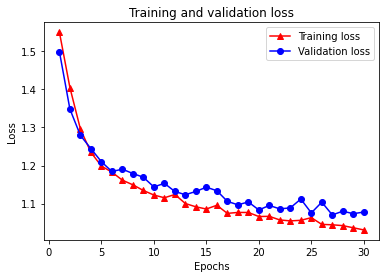

In [24]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

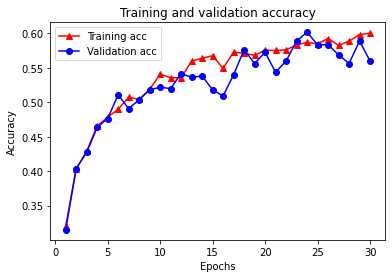

In [25]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

## Graph regularization

We are now ready to try graph regularization using the base model that we built
above. We will use the `GraphRegularization` wrapper class provided by the
Neural Structured Learning framework to wrap the base (CNN) model to include
graph regularization. The rest of the steps for training and evaluating the
graph-regularized model are similar to that of the base model.

### Create graph-regularized model

To assess the incremental benefit of graph regularization, we will create a new
base model instance. This is because `model` has already been trained for a few
iterations, and reusing this trained model to create a graph-regularized model
will not be a fair comparison for `model`.

In [26]:
# Build a new base CNN model.
base_reg_model = make_cnn_model()

In [27]:
# Wrap the base model with graph regularization.
graph_reg_config = nsl.configs.make_graph_reg_config(
  max_neighbors=HPARAMS.num_neighbors,
  multiplier=HPARAMS.graph_regularization_multiplier,
  distance_type=HPARAMS.distance_type,
  sum_over_axis=-1)
graph_reg_model = nsl.keras.GraphRegularization(base_reg_model,
                                                graph_reg_config)

In [28]:
graph_reg_model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
graph_reg_history = graph_reg_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=HPARAMS.train_epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


49/49 [==============================] - 12s 169ms/step - loss: 1.5655 - accuracy: 0.3135 - scaled_graph_loss: 4.3197e-04 - val_loss: 1.5131 - val_accuracy: 0.3691
Epoch 2/30
49/49 [==============================] - 7s 146ms/step - loss: 1.4504 - accuracy: 0.3878 - scaled_graph_loss: 0.0037 - val_loss: 1.3610 - val_accuracy: 0.4382
Epoch 3/30
49/49 [==============================] - 7s 146ms/step - loss: 1.3586 - accuracy: 0.4234 - scaled_graph_loss: 0.0084 - val_loss: 1.2830 - val_accuracy: 0.4455
Epoch 4/30
49/49 [==============================] - 7s 147ms/step - loss: 1.3005 - accuracy: 0.4494 - scaled_graph_loss: 0.0122 - val_loss: 1.2526 - val_accuracy: 0.4709
Epoch 5/30
49/49 [==============================] - 7s 149ms/step - loss: 1.2764 - accuracy: 0.4561 - scaled_graph_loss: 0.0145 - val_loss: 1.2368 - val_accuracy: 0.4491
Epoch 6/30
49/49 [==============================] - 7s 149ms/step - loss: 1.2519 - accuracy: 0.4785 - scaled_graph_loss: 0.0154 - val_loss: 1.2092 - val_acc

### Plot training metrics of the graph-regularized model

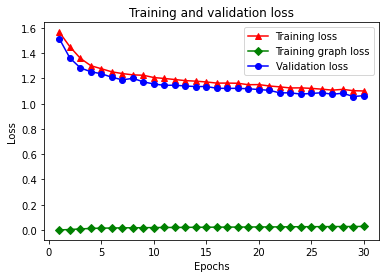

In [30]:
graph_reg_history_dict = graph_reg_history.history

acc = graph_reg_history_dict['accuracy']
val_acc = graph_reg_history_dict['val_accuracy']
loss = graph_reg_history_dict['loss']
graph_loss = graph_reg_history_dict['scaled_graph_loss']
val_loss = graph_reg_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-gD" is for solid green line with diamond markers.
plt.plot(epochs, graph_loss, '-gD', label='Training graph loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

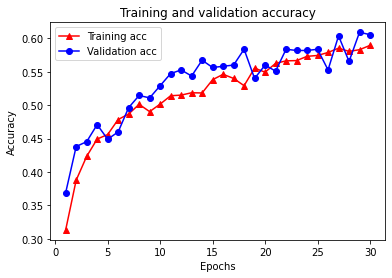

In [31]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

Based on the performances of the two models (with and without graph regularization) we observe that the model performs better with graph regularization. But an ablation study (on the reduced projection dimensionality) reveals a different trend

| Embedding <br>Dim 	| With <br>Graph-reg 	| Without<br>Graph-reg 	|
|:---:	|:---:	|:---:	|
| 128 	| 60.55% 	| 56.00% 	|
| 256 	| 57.82% 	| 55.45% 	|
| 384 	| 58% 	| 60.18% 	|
| 512 	| 57.45% 	| 57.64% 	|

The table above reports the validation top-1 accuracies with and without graph regularization under different reduced embedding dimensionalities. Notice that after 256-d the performance trade-off reverses. We encourage you to further experiment with hyperparameters like `similarity_threshold` and `graph_regularization_multiplier` to study how these hyperparameters affect the final performance. 

## Visualization

In this final section, we visualize the neighbor images as computed by Neural Structured Learning during building the graph. 

In [32]:
sample = next(iter(train_dataset))
sample[0].keys()

dict_keys(['NL_nbr_0_image', 'NL_nbr_0_weight', 'NL_nbr_1_image', 'NL_nbr_1_weight', 'image'])

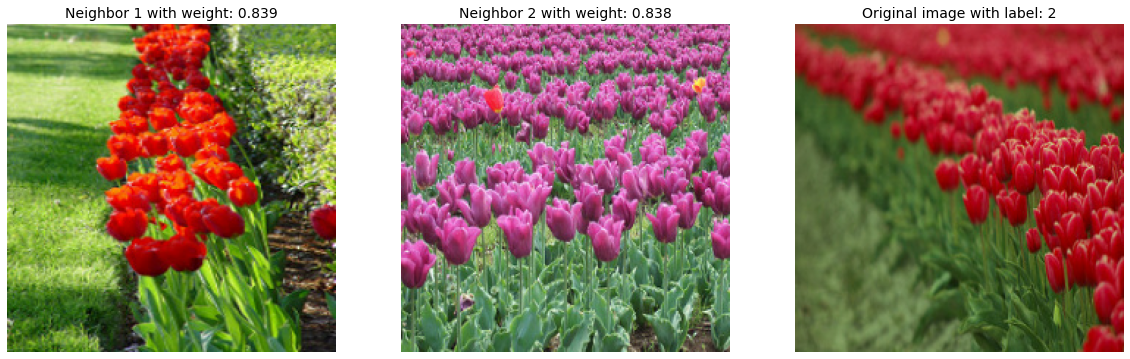

In [33]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(sample[0]["NL_nbr_0_image"][0])
neighbor_one_weight = float(sample[0]["NL_nbr_0_weight"][0].numpy())
plt.title(f"Neighbor 1 with weight: {neighbor_one_weight:.3f}", fontsize=14)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sample[0]["NL_nbr_1_image"][0])
neighbor_two_weight = float(sample[0]["NL_nbr_1_weight"][0].numpy())
plt.title(f"Neighbor 2 with weight: {neighbor_two_weight:.3f}", fontsize=14)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(sample[0]["image"][0])
plt.title(f"Original image with label: {int(sample[1][0])}", fontsize=14)
plt.axis("off")

plt.show()

In the figure above, `weight` denotes the similarity strength of the examples.

## Conclusion

We have demonstrated the use of graph regularization using the Neural Structured
Learning (NSL) framework even when the input does not contain an explicit graph.
We considered the task of flower species' classification of flower images for
which we synthesized a similarity graph based on review embeddings. We encourage
users to experiment further by varying hyperparameters, the amount of
supervision, and by using different model architectures.